In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from scipy import integrate

%matplotlib inline

In the [Chernoff et al 2020 paper](https://ui.adsabs.harvard.edu/abs/2020MNRAS.491..596C/abstract) equation 12 gives the microlensing rate per star per second: 

$\frac{\Gamma}{N_\star} = \int_0^D dr' dl \left(\frac{dn}{dl}\right)'\langle \frac{dA_\perp}{dt} \rangle$.

In the paragraph just above, the authors state that $\langle \frac{dA_\perp}{dt} \rangle \sim lc$.

I take $\left(\frac{dn}{dl}\right)'$ to be $\frac{1}{l}\mathcal{F}(r')\,\mathcal{G}\,\left(\frac{dn}{d\ln{l}}\right)_\text{base}$, as in Equation 3, which invokes clustering via $\mathcal{F}$. In their paper, $\mathcal{G} = 10^2$ as stated in the first paragraph on page 598, and equation 1 states that:

$\left(\frac{dn}{d\ln{l}}\right)_\text{base} = 1.15 \times 10^{-6} \frac{x}{(1+x)^{5/2}} \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \text{kpc}^{-3}$,

where $\mu_{-13} = \frac{G \mu}{c^2} \times 10^{13}$, $x = \frac{l}{l_g}$, $l_g = 0.0206 \, \Gamma_{50} \, \mu_{-13}$ pc, and $\Gamma_{50} = f_{0.2} = \alpha_{0.1} = 1$. The clustering enhancement 

$\mathcal{F}(r) = \max \left(\beta(\mu)\mathcal{E}(r), 1\right) = \max\left(\beta(\mu) \frac{\rho_{DM}(r)}{\Omega_{DM} \rho_{\text{crit}}}, 1\right)$ 

is defined in the second paragraph on the right side of page 599. $\max$ is used to ensure that $\mathcal{F} \geq 1$ always. The functional form of $\beta(\mu)$ is given in Appendix F of [Chernoff and Tye's 2018 paper](https://arxiv.org/pdf/1712.05060.pdf). $\mathcal{E} = \frac{\rho_{DM}(r)}{\Omega_{DM} \rho_{\text{crit}}}$ is defined in equation 5: 

$ \rho_{\text{MW - M31}} = \begin{cases}
\frac{A}{r^{9/4}} & 0 < r < r_1 \\ 
\frac{2^{3/4}A}{(B-r)^{9/4}} & r_1 < r < B
\end{cases} $

where $A = 1.15 \times 10^9 M_\odot / \text{kpc}^{3/4}$, $r_1 = 345$ kpc, and $B = 780$ kpc. I use $\Omega_{DM} = 1/4$ and $\rho_{\text{crit}} = 3 H_0^2/8\pi G$. Finally, I place the observer 8 kpc from the Milky Way center and the source 8 kpc in front of the center of M31, as indicated in table 1 of the 2020 paper.

Combining all this gives:

$\frac{\Gamma}{N_\star} = \int_8^{772}dr' \int_0^\infty dl \, \frac{1}{l}\, \mathcal{F}(r) \, \mathcal{G}\, 1.15 \times 10^{-6} \, \frac{x}{(1+x)^{5/2}} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \text{kpc}^{-3}  lc$

Cancelling the factors of $l$ and using $dl = l_g dx$ gives:

$\frac{\Gamma}{N_\star} = \int_8^{772}dr' \int_0^\infty dx l_g \, c \, \mathcal{F}(r) \, \mathcal{G}\, 1.15 \times 10^{-6} \, \frac{x}{(1+x)^{5/2}} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \text{kpc}^{-3} $.

the $x$ integral gives:

$\int_0^\infty dx \frac{x}{(1+x)^{(5/2)}} = 4/3$.

Finally we have

$\frac{\Gamma}{N_\star} = l_g \, c \, 
\mathcal{G} \, 1.15 \times 10^{-6} \, \frac{4}{3} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \int_8^{772} dr \mathcal{F}(r) \, \text{kpc}^{-3} $

In [2]:
def foo(y):
    return -0.337 - (0.064 * y**2)

def betaOfMu(mu):
    return 10**foo(np.log10(mu * 1e15))

def enhancementFactorOfR(rhoOfR, tensions):
    littleHubble = 0.7
    bigHubble = littleHubble * 100 * u.km / u.s / u.Mpc
    newtonG = 6.674e-11 * u.newton * u.m**2 / u.kg**2
    rhoCritical = 3 * bigHubble**2 / (8 * np.pi * newtonG)
    omegaDM = 1/4
    overdensityDM = rhoOfR / (omegaDM * rhoCritical)
    betas = betaOfMu(tensions)
    betas = betas.reshape(len(betas), 1) # Column of betas to take advantage of python broadcasting
    
    # tempF can have values less than 1
    tempF = (betas * overdensityDM).decompose()
    
    # invoking np.where so the enhancement is never less than homogeneous limit (ie 1)
    enhancementAtR = np.where(tempF > 1, tempF, 1)
    return enhancementAtR

def modelRho(A, r1, r, sourceGalaxyCenter, impactParameter=np.array([0, 0]), C=2**(3/4)):
    # Scoot the sourceGalaxy along y axis to avoid diverging center if needed
    sourceGalaxyCenterPrime = (sourceGalaxyCenter + impactParameter).reshape(2, 1)
    
    # Norm each vector
    rNorm = np.linalg.norm(r, axis=0)
    
    # rPrime is vector from MW center ([0, 0]) when within r1, vector from sourceGalaxyCenterPrime otherwise
    rPrime = np.where(rNorm < r1, r, r - sourceGalaxyCenterPrime)
    rPrimeNorm = np.linalg.norm(rPrime, axis=0)
    rho = np.where(rNorm < r1, A / rPrimeNorm**(9/4), C * A / rPrimeNorm**(9/4))
    return rho

In [3]:
# Here I just define all my values
# First these constants that are all 1
f02 = 1
a01 = 1
gamma50 = 1

# Then all the parts of the event rate calculation except the r integral
tensions = np.logspace(-15, -9, num=7)
mu13 = tensions * 1e13
lg = 0.0206 * gamma50 * mu13 * u.pc
speedOfLight = 2.98e8 * u.m / u.s
gFactor = 1e2
aFactor = 1.15e9 * u.solMass / u.kpc**(3/4)
bFactor = 780 * u.kpc
r1 = 345 * u.kpc
xIntegral = 4/3

# Vectors for doing the r integral along the line of sight
m31Center = np.array([780, 0]) * u.kpc
observerPosition = np.array([8, 0]) * u.kpc
planarSourcePosition = m31Center + np.array([0, 8]) * u.kpc
backSourcePosition = m31Center + np.array([8, 0]) * u.kpc
impactParameter = np.array([0, 0.1]) * u.kpc

# Define lines of sight and rhats for lines of sight, these are defined from observerPosition
planarSourceLineOfSight = planarSourcePosition - observerPosition
planarSourceDistance = np.linalg.norm(planarSourceLineOfSight)
planarSourceRHat = planarSourceLineOfSight / planarSourceDistance

backSourceLineOfSight = backSourcePosition - observerPosition
backSourceDistance = np.linalg.norm(backSourceLineOfSight)
backSourceRHat = backSourceLineOfSight / backSourceDistance

# Make nSteps steps along the LOS to integrate
nSteps = 100000
planarRSteps = np.linspace(0 * u.kpc, planarSourceDistance, num=nSteps)
backRSteps = np.linspace(0 * u.kpc, backSourceDistance, num=nSteps)

# nSteps column vectors from observer to source
planarSourceR = (observerPosition.reshape(2, 1) + 
                 (planarSourceRHat.reshape(2, 1) * planarRSteps))
backSourceR = (observerPosition.reshape(2, 1) + 
               (backSourceRHat.reshape(2, 1) * backRSteps))

# dr for the integration
planarDr = planarRSteps[1] - planarRSteps[0]
backDr = backRSteps[1] - backRSteps[0]

# Calculate rho(r)
planarRho = modelRho(aFactor, r1, planarSourceR, m31Center)
backRho = modelRho(aFactor, r1, backSourceR, m31Center)

# Calculate F(r)
planarEnhancementAtR = enhancementFactorOfR(planarRho, tensions)
backEnhancementAtR = enhancementFactorOfR(backRho, tensions)

# Integrate F(r)dr
planarEnhancementIntegral = integrate.trapz(planarEnhancementAtR, axis=1, dx=planarDr)
planarEnhancementIntegral = planarEnhancementIntegral.reshape(len(planarEnhancementIntegral,))

backEnhancementIntegral = integrate.trapz(backEnhancementAtR, axis=1, dx=backDr)
backEnhancementIntegral = backEnhancementIntegral.reshape(len(backEnhancementIntegral,))

# Values from table C1 of the 2020 paper
tObs = 1 * u.yr
tableC1PlanarResults = np.array([9.66e-6, 2.64e-6, 5.36e-7, 8.11e-8, 
                                 9.14e-9, 7.67e-10, 1.51e-12])
tableC1BackResults = np.array([2.46e-3, 6.72e-4, 1.36e-4, 2.07e-5, 
                                 2.33e-6, 1.95e-7, 1.52e-12])

Here I plot the enhancement factors along the line of sight just to make sure everything looks reasonable.

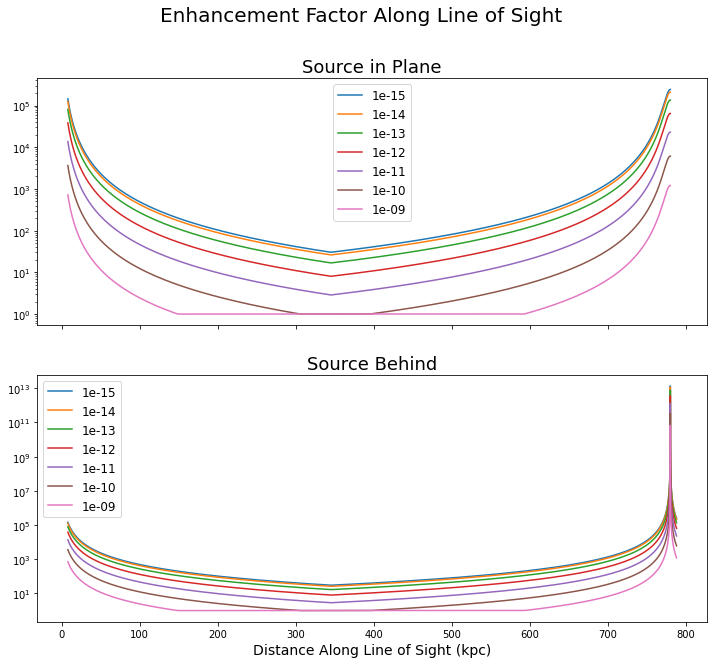

In [4]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 10))
for f, tension in zip(planarEnhancementAtR, tensions):
    axs[0].semilogy(np.linalg.norm(planarSourceR, axis=0), f, label=f"{tension}")
    
for f, tension in zip(backEnhancementAtR, tensions):
    axs[1].semilogy(np.linalg.norm(backSourceR, axis=0), f, label=f"{tension}")
    
for ax in axs.ravel():
    ax.legend(fontsize=12)
    
fig.suptitle("Enhancement Factor Along Line of Sight", fontsize=20)
axs[0].set_title("Source in Plane", fontsize=18)
axs[1].set_title("Source Behind", fontsize=18)
axs[1].set_xlabel("Distance Along Line of Sight (kpc)", fontsize=14)
plt.show(fig)

In [5]:
#Calculate event rates for my tensions
planarEventRate = (lg * speedOfLight * gFactor * 1.15e-6 * xIntegral
             * (f02 * np.sqrt(a01) / (gamma50 * mu13)**(3/2)) *
             planarEnhancementIntegral * u.kpc**(-3))
nPlanarEvents = (planarEventRate * tObs).decompose()

backEventRate = (lg * speedOfLight * gFactor * 1.15e-6 * xIntegral
             * (f02 * np.sqrt(a01) / (gamma50 * mu13)**(3/2)) *
             backEnhancementIntegral * u.kpc**(-3))
nBackEvents = (backEventRate * tObs).decompose()

print(nPlanarEvents)
print(nBackEvents)

[3.42133888e-05 9.33675780e-06 1.89756252e-06 2.87207709e-07
 3.23739799e-08 2.71801017e-09 1.72488817e-10]
[1.49111602e+00 4.06922248e-01 8.27011283e-02 1.25173223e-02
 1.41094939e-03 1.18443556e-04 7.40477022e-06]


In [6]:
print(nPlanarEvents / tableC1PlanarResults)
print(nBackEvents / tableC1BackResults)

[  3.54175868   3.53665068   3.54022858   3.54140209   3.54201093
   3.54368992 114.23100448]
[6.06144722e+02 6.05539059e+02 6.08096532e+02 6.04701560e+02
 6.05557676e+02 6.07402849e+02 4.87155936e+06]


I'm consistently high by roughly the same factor for all tensions in both the planar and back source calculations (different factor depending on source position though), except for the 1e-9 tension case, strangely...

nEvents should be proportional to $\frac{l_g}{\mu_{-13}^{3/2}} \int dr \mathcal{F}(r) $, as I understand it.

In [7]:
print(nPlanarEvents / (lg * planarEnhancementIntegral/mu13**(3/2)),
      nBackEvents / (lg * backEnhancementIntegral/mu13**(3/2)))

[4.67311279e-11 4.67311279e-11 4.67311279e-11 4.67311279e-11
 4.67311279e-11 4.67311279e-11 4.67311279e-11] 1 / (kpc pc) [4.67311279e-11 4.67311279e-11 4.67311279e-11 4.67311279e-11
 4.67311279e-11 4.67311279e-11 4.67311279e-11] 1 / (kpc pc)


They are, so that's good.

In [8]:
print(tableC1PlanarResults / (lg * planarEnhancementIntegral/mu13**(3/2)))
print(tableC1BackResults / (lg * backEnhancementIntegral/mu13**(3/2)))

[1.31943286e-11 1.32133852e-11 1.32000312e-11 1.31956572e-11
 1.31933889e-11 1.31871379e-11 4.09093206e-13] 1 / (kpc pc)
[7.70956608e-14 7.71727722e-14 7.68482065e-14 7.72796548e-14
 7.71703996e-14 7.69359708e-14 9.59264261e-18] 1 / (kpc pc)


The table C1 results are also all proportional to my $\frac{l_g}{\mu_{-13}^{3/2}} \int dr \mathcal{F}(r) $, but by a different factor, _except_ the 1e-9 case.

So there are two questions here:

1: Why are my results different from the table C1 results? (usually)

2: What's going on with the 1e-9 tension case? 